In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations

In [3]:
raw_df = pd.read_excel('RFLFSODataFull.xlsx')

In [4]:
fso_df = raw_df.drop(columns=['RFL_Att']) # 2. Dataset excluding "RFL_Att"

## FEATURE SELECTION

In [8]:
def feature_selection_algorithm(data, target_variable):
    """
    Implement the given algorithm for feature selection.
    
    Parameters:
        data (pd.DataFrame): The dataset containing features and the target variable.
        target_variable (str): The name of the target variable column.
        
    Returns:
        pd.DataFrame: A table containing the removed feature, RMSE, and R^2 values.
    """
    # Separate features and target variable
    X = data.drop(columns=[target_variable])
    y = data[target_variable]
    
    # Initialize an empty table R
    R = []
    
    # List of predictor variables S
    S = list(X.columns)
    
    while S:
        # Train a Random Forest model using the features in S
        rf = RandomForestRegressor(random_state=42, oob_score=True)
        rf.fit(X[S], y)
        
        # Calculate RMSE and R^2 values
        y_pred = rf.oob_prediction_
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        
        # Get feature importances
        feature_importances = rf.feature_importances_
        
        # Identify the least important predictor
        least_important_index = np.argmin(feature_importances)
        least_important_feature = S[least_important_index]
        
        # Add the removed feature and its metrics to the table
        R.append((least_important_feature, rmse, r2))
        
        # Remove the least important feature from S
        S.pop(least_important_index)
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(R, columns=["Removed Feature", "RMSE", "R2"])
    
    # Print the entire table
    print("Feature Removal Table with RMSE and R2 values:")
    print(results_df)
    
    # Get the top 10 important features
    top_features = results_df.head(10)
    
    # Print the top 10 important features
    print("\nTop 10 Important Features:")
    print(top_features)
    
    return results_df

# Example usage:
# Assuming `data` is your dataset and 'RFL_Att' is the target variable
results = feature_selection_algorithm(fso_df, target_variable='FSO_Att')


Feature Removal Table with RMSE and R2 values:
          Removed Feature      RMSE        R2
0               Frequency  0.760940  0.962005
1        RainIntensityMin  0.759912  0.962108
2        RainIntensityMax  0.759826  0.962117
3               SYNOPCode  0.759328  0.962166
4           WindDirection  0.759926  0.962107
5           RainIntensity  0.751372  0.962955
6               WindSpeed  0.749250  0.963164
7     AbsoluteHumidityMin  0.748875  0.963201
8     AbsoluteHumidityMax  0.741862  0.963887
9            WindSpeedMin  0.731493  0.964889
10           WindSpeedMax  0.743091  0.963767
11         TemperatureMax  0.758014  0.962297
12          VisibilityMax  0.751954  0.962898
13  TemperatureDifference  0.746506  0.963433
14         ParticulateMax  0.825613  0.955273
15       RelativeHumidity  0.824298  0.955415
16                   Time  0.823010  0.955554
17         TemperatureMin  1.070076  0.924864
18            Particulate  1.061180  0.926108
19       AbsoluteHumidity  1.0621

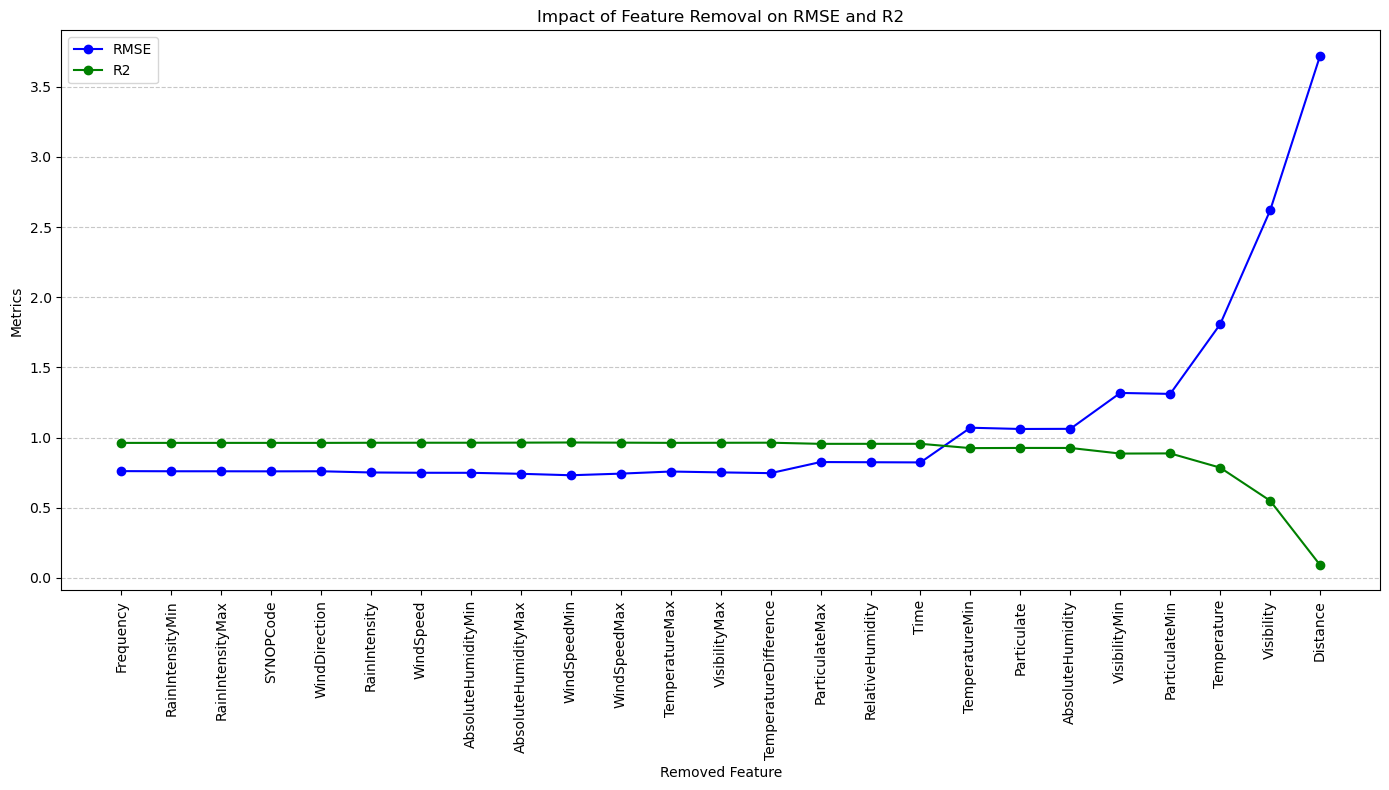

In [42]:


# Plotting
plt.figure(figsize=(14, 8))

# RMSE Plot
plt.plot(results["Removed Feature"], results["RMSE"], marker='o', label="RMSE", color='blue')

# R2 Plot
plt.plot(results["Removed Feature"], results["R2"], marker='o', label="R2", color='green')

# Customizing the plot
plt.xticks(rotation=90)
plt.xlabel("Removed Feature")
plt.ylabel("Metrics")
plt.title("Impact of Feature Removal on RMSE and R2")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("Feature Importance FSO.png", dpi=300)
plt.show()


## SYNOP CODE 

In [ ]:
def feature_selection_by_synop(data, target_variable, top_n=10):
    """
    Run the feature selection algorithm for each SYNOPCode.
    
    Parameters:
        data (pd.DataFrame): The dataset containing features and the target variable.
        target_variable (str): The name of the target variable column.
        top_n (int): Number of top features for each SYNOPCode.
        
    Returns:
        dict: A dictionary where keys are SYNOPCodes and values are DataFrames
              containing the top features, RMSE, and R² values for each code.
    """
    # Extract unique SYNOPCodes
    synop_codes = data['SYNOPCode'].unique()
    
    # Dictionary to store results for each SYNOPCode
    synop_results = {}
    
    for code in synop_codes:
        print(f"Processing SYNOPCode: {code}")
        
        # Filter the dataset for the current SYNOPCode
        subset_data = data[data['SYNOPCode'] == code]
        
        # Separate features and target variable
        X = subset_data.drop(columns=[target_variable, 'SYNOPCode'])
        y = subset_data[target_variable]
        
        # Initialize an empty table R
        R = []
        
        # List of predictor variables S
        S = list(X.columns)
        
        while S:
            # Train a Random Forest model using the features in S
            fso = RandomForestRegressor(random_state=42, oob_score=True)
            fso.fit(X[S], y)
            
            # Calculate RMSE and R^2 values
            y_pred = fso.oob_prediction_
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            r2 = r2_score(y, y_pred)
            
            # Get feature importances
            feature_importances = fso.feature_importances_
            
            # Identify the least important predictor
            least_important_index = np.argmin(feature_importances)
            least_important_feature = S[least_important_index]
            
            # Add the removed feature and its metrics to the table
            R.append((least_important_feature, rmse, r2))
            
            # Remove the least important feature from S
            S.pop(least_important_index)
        
        # Convert the results to a DataFrame
        results_df = pd.DataFrame(R, columns=["Removed Feature", "RMSE", "R2"])
        
        # Get the top N important features
        top_features = results_df.tail(top_n)
        
        # Store the top features for the current SYNOPCode
        synop_results[code] = top_features
    
    return synop_results

# Example usage:
# Assuming `data` is your dataset and 'FSO_Att' is the target variable
top_features_by_synop = feature_selection_by_synop(data=fso_df, target_variable='FSO_Att', top_n=10)

# To access results for a specific SYNOPCode, use:

synop_codes = fso_df['SYNOPCode'].unique()
for code in synop_codes:
    print("For SYNOP CODE: ",code)
    print(top_features_by_synop[code])

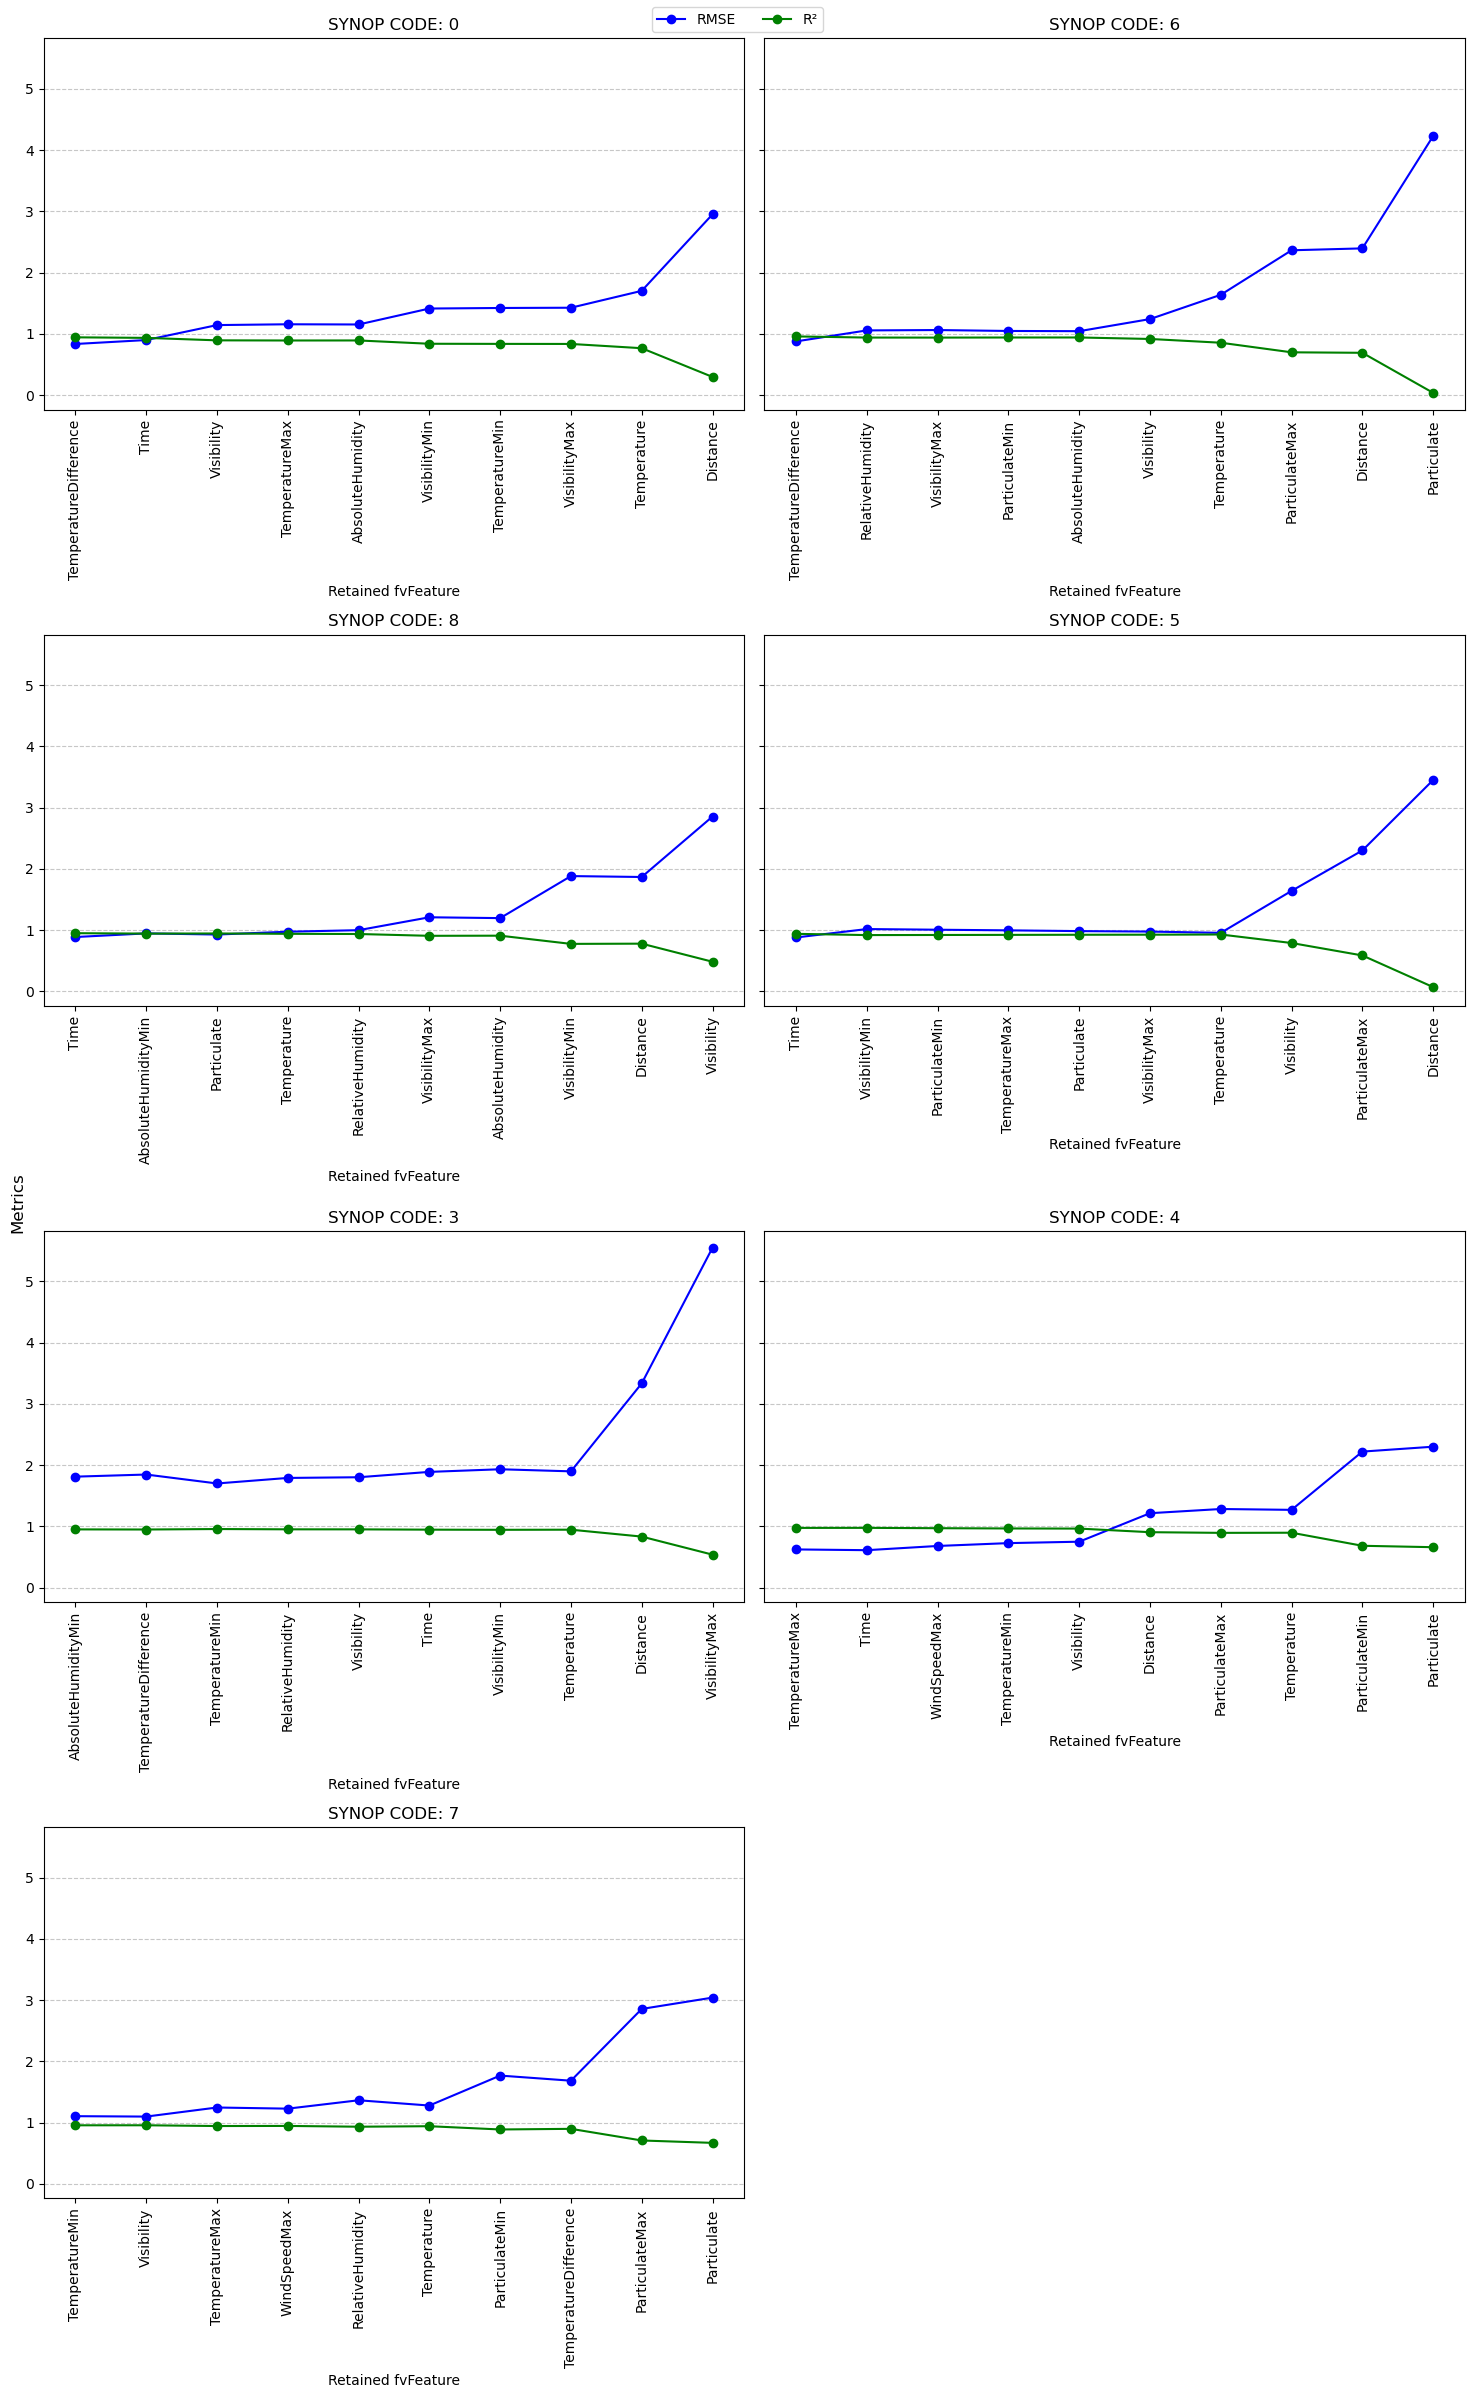

In [48]:
import math

# Assuming `synop_codes` is a list of unique SYNOP codes
# Assuming `top_features_by_synop` is a dictionary with SYNOP codes as keys and DataFrames as values

# Calculate the number of rows needed (2 plots per row)
n_cols = 2
n_rows = math.ceil(len(synop_codes) / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows), sharey=True)

# Flatten the axes array to iterate easily, in case of multiple rows
axes = axes.flatten()

# Loop through each SYNOP code and corresponding subplot
for idx, code in enumerate(synop_codes):
    # Get the DataFrame for the current SYNOP code
    df = top_features_by_synop[code]

    # Plot for the current SYNOP Code
    axes[idx].plot(df["Removed Feature"], df["RMSE"], marker='o', label="RMSE", color='blue')
    axes[idx].plot(df["Removed Feature"], df["R2"], marker='o', label="R²", color='green')

    # Customizing the subplot
    axes[idx].set_title(f"SYNOP CODE: {code}")
    axes[idx].set_xlabel("Retained fvFeature")
    axes[idx].tick_params(axis='x', rotation=90)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

# Hide any unused axes if the number of plots is less than available subplots
for i in range(len(synop_codes), len(axes)):
    fig.delaxes(axes[i])

# Set the common Y-label and legend
fig.supylabel("Metrics")
fig.tight_layout()
fig.legend(["RMSE", "R²"], loc='upper center', ncol=2)

plt.savefig("Feature Importance FSO (SYNOPCODE).png", dpi=300)

# Show the plot
plt.show()


## GENERIC RF MODEL

In [24]:
from sklearn.model_selection import train_test_split

# Selected features based on importance
selected_features = [
    "Distance",
    "Visibility",
    "Temperature",
    "ParticulateMin",
    "VisibilityMin",
    "Particulate",
    "TemperatureMin",
    "Time",
    "RelativeHumidity",
    "SYNOPCode"
]

def train_fso_model(data, target_variable, selected_features):
    """
    Train a Random Forest model using selected features.
    
    Parameters:
        data (pd.DataFrame): The dataset containing features and the target variable.
        target_variable (str): The name of the target variable column.
        selected_features (list): List of selected features for training.
    
    Returns:
        RandomForestRegressor: The trained Random Forest model.
        dict: Evaluation metrics (RMSE and R²) on the test set.
    """
    # Filter the data for the selected features and target variable
    X = data[selected_features]
    y = data[target_variable]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the Random Forest Regressor
    fso = RandomForestRegressor(random_state=42)
    
    # Train the model
    fso.fit(X_train, y_train)
    
    # Make predictions
    y_pred = fso.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Print metrics
    print("Random Forest Model Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    return fso, {"RMSE": rmse, "R²": r2}

# Example usage:
# Assuming `data` is your dataset and 'RFL_Att' is the target variable
fso_model, metrics = train_fso_model(fso_df, target_variable='FSO_Att', selected_features=selected_features)


Random Forest Model Performance:
RMSE: 0.8628
R²: 0.9504


## SPECIFIC RF MODEL

In [36]:
def train_fso_by_synop(data, target_variable, top_features_by_synop):
    """
    Train Random Forest models for each SYNOPCode using their top features.
    
    Parameters:
        data (pd.DataFrame): The dataset containing features and the target variable.
        target_variable (str): The name of the target variable column.
        top_features_by_synop (dict): A dictionary containing top features for each SYNOPCode.
        
    Returns:
        dict: A dictionary where keys are SYNOPCodes and values are the model performance
              (RMSE and R² values) for each code.
    """
    # Dictionary to store model performance for each SYNOPCode
    synop_performance = {}
    
    for code, top_features_df in top_features_by_synop.items():
        print(f"Training RF Model for SYNOPCode: {code}")
        
        # Extract top features for the current SYNOPCode
        top_features = top_features_df['Removed Feature'].tolist()
        
        # Filter the dataset for the current SYNOPCode
        subset_data = data[data['SYNOPCode'] == code]
        
        # Prepare training data
        X = subset_data[top_features]
        y = subset_data[target_variable]
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Initialize and train the Random Forest model
        fso = RandomForestRegressor(random_state=42)
        fso.fit(X_train, y_train)
        
        # Make predictions
        y_pred = fso.predict(X_test)
        
        # Calculate RMSE and R²
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Store the performance metrics
        synop_performance[code] = {"RMSE": rmse, "R2": r2}
        
        print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    return synop_performance

# Example usage:
# Assuming `data` is your dataset, 'RFL_Att' is the target variable, and `top_features_by_synop`
# is the dictionary returned by the feature_selection_by_synop function.

synop_performance = train_fso_by_synop(data=fso_df, target_variable='FSO_Att', top_features_by_synop=top_features_by_synop)

# Example to access results:
print(synop_performance)


Training RF Model for SYNOPCode: 0
RMSE: 0.8689, R²: 0.9405
Training RF Model for SYNOPCode: 6
RMSE: 0.8934, R²: 0.9563
Training RF Model for SYNOPCode: 8
RMSE: 0.9610, R²: 0.9373
Training RF Model for SYNOPCode: 5
RMSE: 0.9744, R²: 0.9258
Training RF Model for SYNOPCode: 3
RMSE: 1.7933, R²: 0.9631
Training RF Model for SYNOPCode: 4
RMSE: 0.6694, R²: 0.9710
Training RF Model for SYNOPCode: 7
RMSE: 0.9055, R²: 0.9694
{0: {'RMSE': 0.8688701490964962, 'R2': 0.9405295447832567}, 6: {'RMSE': 0.8933855956135638, 'R2': 0.9562841187468734}, 8: {'RMSE': 0.9610332446909263, 'R2': 0.9373481980721629}, 5: {'RMSE': 0.9743992153291942, 'R2': 0.9257949396054718}, 3: {'RMSE': 1.7932695353044863, 'R2': 0.9631110336993527}, 4: {'RMSE': 0.6694465852141056, 'R2': 0.970996862426155}, 7: {'RMSE': 0.905520036105964, 'R2': 0.9693577769586766}}


In [38]:
rmse_values = [metrics["RMSE"] for metrics in synop_performance.values()]
r2_values = [metrics["R2"] for metrics in synop_performance.values()]
    
# Calculate averages
avg_rmse = sum(rmse_values) / len(rmse_values)
avg_r2 = sum(r2_values) / len(r2_values)
    
print("Average RMSE: ", avg_rmse, "\nAverage R²: ", avg_r2)

Average RMSE:  1.0094177659078194 
Average R²:  0.9519174963274214
